In [ ]:
!pip install -q snscrape==0.3.4

In [ ]:
import pandas as pd
import snscrape.modules.twitter as sntwitter
import itertools

In [ ]:
# Add Google Drive as an accessible path (Optional if you are running from Jupyter Notebook)
from google.colab import drive
drive.mount('/content/drive')

# change path to the designated google drive folder
# otherwise, data will be saved in /content folder which you may have issue locating
%cd /content/drive/My Drive/Colab Notebooks/CSS Project

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/CSS Project


In [ ]:
from_date = '2016-01-01'
end_date = '2020-12-31'

"discrimination"

In [ ]:
df_city = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
    'gender near:"Singapore" within:10km lang:en since:'+  from_date + ' until:' + end_date + ' -filter:links -filter:replies -filter:retweets').get_items(), 10000))[['date', 'content']]

In [ ]:
loc = '1.3521, 103.8198, 10km'
df_coord = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
    'gender geocode:"{}"'.format(loc) + 'lang:en since:' +  from_date + ' until:' + end_date + ' -filter:links -filter:replies -filter:retweets').get_items(), 10000))[['date', 'content']]

In [ ]:
print(df_city.shape)
print(df_coord.shape)

(32, 2)
(32, 2)


In [ ]:
common_rows = df_coord.merge(df_city, how='inner')
print(common_rows.shape)
common_rows.head()

(18, 2)


,date,content
0,2020-12-17 12:11:05+00:00,"SOMETIMES, Men don’t understand why we feel wh..."
1,2020-10-22 14:36:12+00:00,exchange each other’s nudes w a friend from th...
2,2020-10-17 14:18:58+00:00,Two people of the opposite gender can go out t...
3,2020-09-13 15:01:35+00:00,the gender of the child that started the calif...
4,2020-09-12 16:13:09+00:00,i still dont get the concept of gender reveal ...


In [ ]:
common_rows.to_csv(f'gendersg_tweets.csv')

**Cleaning of text**

In [ ]:
### Let's download ```smt203util.py``` Below code should download the file in the same folder where your jupyter notebook is. 
!wget https://raw.githubusercontent.com/anjisun221/css_codes/main/ay21t1/Lab03_text_analysis/smt203util.py

--2021-10-22 15:17:41--  https://raw.githubusercontent.com/anjisun221/css_codes/main/ay21t1/Lab03_text_analysis/smt203util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3034 (3.0K) [text/plain]
Saving to: ‘smt203util.py.2’

smt203util.py.2     100%[===================>]   2.96K  --.-KB/s    in 0.001s  

2021-10-22 15:17:41 (3.83 MB/s) - ‘smt203util.py.2’ saved [3034/3034]



In [ ]:
from smt203util import *

In [ ]:
df = pd.read_csv('gendersg_tweets.csv')

print(df.shape)
df.head()

(18, 3)


,Unnamed: 0,date,content
0,0,2020-12-17 12:11:05+00:00,"SOMETIMES, Men don’t understand why we feel wh..."
1,1,2020-10-22 14:36:12+00:00,exchange each other’s nudes w a friend from th...
2,2,2020-10-17 14:18:58+00:00,Two people of the opposite gender can go out t...
3,3,2020-09-13 15:01:35+00:00,the gender of the child that started the calif...
4,4,2020-09-12 16:13:09+00:00,i still dont get the concept of gender reveal ...


In [ ]:
import re 
import string

def clean_text_round1(text):
    '''Make text lowercase, remove punctuation and words containing numbers and urls.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('^https?:\/\/.*[\r\n]*', '', text)
    return text

In [ ]:
df['clean_text_1'] = df['content'].apply(clean_text_round1)
df.head()

,Unnamed: 0,date,content,clean_text_1
0,0,2020-12-17 12:11:05+00:00,"SOMETIMES, Men don’t understand why we feel wh...",sometimes men don’t understand why we feel wha...
1,1,2020-10-22 14:36:12+00:00,exchange each other’s nudes w a friend from th...,exchange each other’s nudes w a friend from th...
2,2,2020-10-17 14:18:58+00:00,Two people of the opposite gender can go out t...,two people of the opposite gender can go out t...
3,3,2020-09-13 15:01:35+00:00,the gender of the child that started the calif...,the gender of the child that started the calif...
4,4,2020-09-12 16:13:09+00:00,i still dont get the concept of gender reveal ...,i still dont get the concept of gender reveal ...


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
def clean_text_round2(text):
    return ' '.join([word for word in text.split() if word not in (stop)])

In [ ]:
df['clean_text_2'] = df['clean_text_1'].apply(clean_text_round2)
df.head()

,Unnamed: 0,date,content,clean_text_1,clean_text_2
0,0,2020-12-17 12:11:05+00:00,"SOMETIMES, Men don’t understand why we feel wh...",sometimes men don’t understand why we feel wha...,sometimes men don’t understand feel feel girl ...
1,1,2020-10-22 14:36:12+00:00,exchange each other’s nudes w a friend from th...,exchange each other’s nudes w a friend from th...,exchange other’s nudes w friend opposite gende...
2,2,2020-10-17 14:18:58+00:00,Two people of the opposite gender can go out t...,two people of the opposite gender can go out t...,two people opposite gender go together couple ...
3,3,2020-09-13 15:01:35+00:00,the gender of the child that started the calif...,the gender of the child that started the calif...,gender child started california fires fire bre...
4,4,2020-09-12 16:13:09+00:00,i still dont get the concept of gender reveal ...,i still dont get the concept of gender reveal ...,still dont get concept gender reveal parties l...


In [ ]:
## Create ```word_counts``` folder 
import os
os.makedirs('word_counts', exist_ok=True)

In [ ]:
def count_words_from_dataframe(df):
    result_dict = {}
    # iterate rows of dataframe 
    for index, row in df.iterrows():
        text = row['clean_text_2']
        
        # this will split a sentence into words 
        tokens = text.split()
        
        # iterate each word 
        for i in range(0, len(tokens)):
            token = tokens[i]
            try:
                result_dict[token] += 1
            except KeyError:
                result_dict[token] = 1
                    
    return result_dict

In [ ]:
gendersg = count_words_from_dataframe(df)
my_dict = gendersg

with open('word_counts/gendersg_dict.csv', 'w') as f:
  for key in my_dict.keys():
    f.write("%s,%s\n"%(key,my_dict[key]))

In [ ]:
### Import relevant libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import re
from PIL import Image
from os import path
import csv

### this function will creat wordcloud based on word frequencies and save them into files under plot. 
def makeImage(termDict, outputfile):
    
    wc = WordCloud(max_font_size=60, width=1280, height=720, background_color="white")    

    ### generate word cloud using frequencies!
    wc.generate_from_frequencies(termDict)
    wc.to_file(outputfile+".png")
    wc.to_file(outputfile+".pdf")
    
    ### show the figure
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show() 

In [ ]:
### Create ```plot``` folder 
os.makedirs('plot', exist_ok=True)

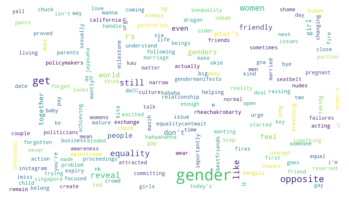

In [ ]:
brandname = "gendersg"
### We're using one of the utility function! "read_word_count_file"
fullTermsDict = read_word_count_file(f'word_counts/gendersg_dict.csv')
outputfile = f"./plot/wordcloud_count_unigram_{brandname}"
makeImage(fullTermsDict, outputfile)

"unfair"

In [ ]:
df_city = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
    'unfair near:"Singapore" within:10km lang:en since:'+  from_date + ' until:' + end_date + ' -filter:links -filter:replies -filter:retweets').get_items(), 10000))[['date', 'content']]

In [ ]:
loc = '1.3521, 103.8198, 10km'
df_coord = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
    'unfair geocode:"{}"'.format(loc) + 'lang:en since:' +  from_date + ' until:' + end_date + ' -filter:links -filter:replies -filter:retweets').get_items(), 10000))[['date', 'content']]

In [ ]:
print(df_city.shape)
print(df_coord.shape)

(21, 2)
(364, 2)


In [ ]:
common_rows = df_coord.merge(df_city, how='inner')
print(common_rows.shape)
common_rows.head()

(16, 2)


,date,content
0,2020-12-16 18:04:50+00:00,so fucking unfair fuck fuck fuck you
1,2020-12-16 17:57:57+00:00,i fucking hate you. its always been you. never...
2,2020-12-16 14:54:54+00:00,Can I just point out one thing?\n\nI just find...
3,2020-12-01 03:58:06+00:00,this is so unfair :D
4,2020-11-29 09:45:07+00:00,Today someone asked if I'm bf-ing my baby and ...


In [ ]:
common_rows.to_csv(f'unfairsg_tweets.csv')

In [ ]:
df = pd.read_csv('unfairsg_tweets.csv')

print(df.shape)
df.head()

(16, 3)


,Unnamed: 0,date,content
0,0,2020-12-16 18:04:50+00:00,so fucking unfair fuck fuck fuck you
1,1,2020-12-16 17:57:57+00:00,i fucking hate you. its always been you. never...
2,2,2020-12-16 14:54:54+00:00,Can I just point out one thing?\n\nI just find...
3,3,2020-12-01 03:58:06+00:00,this is so unfair :D
4,4,2020-11-29 09:45:07+00:00,Today someone asked if I'm bf-ing my baby and ...


In [ ]:
df['clean_text_1'] = df['content'].apply(clean_text_round1)
df.head()

,Unnamed: 0,date,content,clean_text_1
0,0,2020-12-16 18:04:50+00:00,so fucking unfair fuck fuck fuck you,so fucking unfair fuck fuck fuck you
1,1,2020-12-16 17:57:57+00:00,i fucking hate you. its always been you. never...,i fucking hate you its always been you never m...
2,2,2020-12-16 14:54:54+00:00,Can I just point out one thing?\n\nI just find...,can i just point out one thing\n\ni just find ...
3,3,2020-12-01 03:58:06+00:00,this is so unfair :D,this is so unfair d
4,4,2020-11-29 09:45:07+00:00,Today someone asked if I'm bf-ing my baby and ...,today someone asked if im bfing my baby and my...


In [ ]:
df['clean_text_2'] = df['clean_text_1'].apply(clean_text_round2)
df.head()

,Unnamed: 0,date,content,clean_text_1,clean_text_2
0,0,2020-12-16 18:04:50+00:00,so fucking unfair fuck fuck fuck you,so fucking unfair fuck fuck fuck you,fucking unfair fuck fuck fuck
1,1,2020-12-16 17:57:57+00:00,i fucking hate you. its always been you. never...,i fucking hate you its always been you never m...,fucking hate always never fucking unfair
2,2,2020-12-16 14:54:54+00:00,Can I just point out one thing?\n\nI just find...,can i just point out one thing\n\ni just find ...,point one thing find unfair heartless someone ...
3,3,2020-12-01 03:58:06+00:00,this is so unfair :D,this is so unfair d,unfair
4,4,2020-11-29 09:45:07+00:00,Today someone asked if I'm bf-ing my baby and ...,today someone asked if im bfing my baby and my...,today someone asked im bfing baby heart breaks...


In [ ]:
unfairsg = count_words_from_dataframe(df)
my_dict = unfairsg

with open('word_counts/unfairsg_dict.csv', 'w') as f:
  for key in my_dict.keys():
    f.write("%s,%s\n"%(key,my_dict[key]))

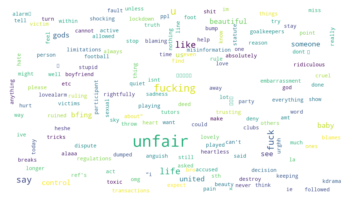

In [ ]:
brandname = "unfairsg"
### We're using one of the utility function! "read_word_count_file"
fullTermsDict = read_word_count_file(f'word_counts/unfairsg_dict.csv')
outputfile = f"./plot/wordcloud_count_unigram_{brandname}"
makeImage(fullTermsDict, outputfile)

"women"

In [ ]:
df_city = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
    'women near:"Singapore" within:10km lang:en since:'+  from_date + ' until:' + end_date + ' -filter:links -filter:replies -filter:retweets').get_items(), 10000))[['date', 'content']]

In [ ]:
loc = '1.3521, 103.8198, 10km'
df_coord = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
    'women geocode:"{}"'.format(loc) + 'lang:en since:' +  from_date + ' until:' + end_date + ' -filter:links -filter:replies -filter:retweets').get_items(), 10000))[['date', 'content']]

In [ ]:
print(df_city.shape)
print(df_coord.shape)

(753, 2)
(955, 2)


In [ ]:
common_rows = df_coord.merge(df_city, how='inner')
print(common_rows.shape)
common_rows.head()

(276, 2)


,date,content
0,2020-12-30 05:25:55+00:00,It’s always fun to eavesdrop on church youth g...
1,2020-12-30 04:41:10+00:00,stopppp ruininggggg women
2,2020-12-30 03:47:38+00:00,"Without really planning on it, most of the boo..."
3,2020-12-26 04:31:20+00:00,I am starting to think there was a secret 14 m...
4,2020-12-25 03:24:05+00:00,The Ripper docu clearly telling us — women tha...


In [ ]:
common_rows.to_csv(f'womensg_tweets.csv')

In [ ]:
df = pd.read_csv('womensg_tweets.csv')

print(df.shape)
df.head()

(276, 3)


,Unnamed: 0,date,content
0,0,2020-12-30 05:25:55+00:00,It’s always fun to eavesdrop on church youth g...
1,1,2020-12-30 04:41:10+00:00,stopppp ruininggggg women
2,2,2020-12-30 03:47:38+00:00,"Without really planning on it, most of the boo..."
3,3,2020-12-26 04:31:20+00:00,I am starting to think there was a secret 14 m...
4,4,2020-12-25 03:24:05+00:00,The Ripper docu clearly telling us — women tha...


In [ ]:
df['clean_text_1'] = df['content'].apply(clean_text_round1)
df.head()

,Unnamed: 0,date,content,clean_text_1
0,0,2020-12-30 05:25:55+00:00,It’s always fun to eavesdrop on church youth g...,it’s always fun to eavesdrop on church youth g...
1,1,2020-12-30 04:41:10+00:00,stopppp ruininggggg women,stopppp ruininggggg women
2,2,2020-12-30 03:47:38+00:00,"Without really planning on it, most of the boo...",without really planning on it most of the book...
3,3,2020-12-26 04:31:20+00:00,I am starting to think there was a secret 14 m...,i am starting to think there was a secret men...
4,4,2020-12-25 03:24:05+00:00,The Ripper docu clearly telling us — women tha...,the ripper docu clearly telling us — women tha...


In [ ]:
df['clean_text_2'] = df['clean_text_1'].apply(clean_text_round2)
df.head()

,Unnamed: 0,date,content,clean_text_1,clean_text_2
0,0,2020-12-30 05:25:55+00:00,It’s always fun to eavesdrop on church youth g...,it’s always fun to eavesdrop on church youth g...,it’s always fun eavesdrop church youth groups ...
1,1,2020-12-30 04:41:10+00:00,stopppp ruininggggg women,stopppp ruininggggg women,stopppp ruininggggg women
2,2,2020-12-30 03:47:38+00:00,"Without really planning on it, most of the boo...",without really planning on it most of the book...,without really planning books ive read year wo...
3,3,2020-12-26 04:31:20+00:00,I am starting to think there was a secret 14 m...,i am starting to think there was a secret men...,starting think secret menwomen orgy mandarin o...
4,4,2020-12-25 03:24:05+00:00,The Ripper docu clearly telling us — women tha...,the ripper docu clearly telling us — women tha...,ripper docu clearly telling us — women men big...


In [ ]:
womensg = count_words_from_dataframe(df)
my_dict = womensg

with open('word_counts/womensg_dict.csv', 'w') as f:
  for key in my_dict.keys():
    f.write("%s,%s\n"%(key,my_dict[key]))

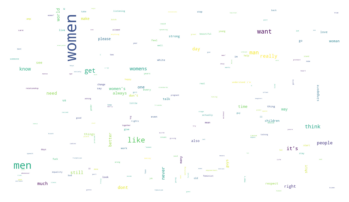

In [ ]:
brandname = "womensg"
### We're using one of the utility function! "read_word_count_file"
fullTermsDict = read_word_count_file(f'word_counts/womensg_dict.csv')
outputfile = f"./plot/wordcloud_count_unigram_{brandname}"
makeImage(fullTermsDict, outputfile)

"equal"

In [ ]:
df_city = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
    'equal near:"Singapore" within:10km lang:en since:'+  from_date + ' until:' + end_date + ' -filter:links -filter:replies -filter:retweets').get_items(), 10000))[['date', 'content']]

In [ ]:
loc = '1.3521, 103.8198, 10km'
df_coord = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
    'equal geocode:"{}"'.format(loc) + 'lang:en since:' +  from_date + ' until:' + end_date + ' -filter:links -filter:replies -filter:retweets').get_items(), 10000))[['date', 'content']]

In [ ]:
print(df_city.shape)
print(df_coord.shape)

(29, 2)
(115, 2)


In [ ]:
common_rows = df_coord.merge(df_city, how='inner')
print(common_rows.shape)
common_rows.head()

(14, 2)


,date,content
0,2020-09-28 13:07:35+00:00,even if u wna say religion isnt equal to human...
1,2020-06-11 07:48:57+00:00,4 hours of Bollywood is like equal to 16episod...
2,2020-06-10 01:22:46+00:00,"You say black lives matter, but segregate the ..."
3,2020-06-02 13:05:23+00:00,I just hope that we will learn our lesson and ...
4,2020-04-16 12:18:53+00:00,ZOOM CALLS DON'T EQUAL PRODUCTIVITY\nZOOM CALL...


In [ ]:
common_rows.to_csv(f'equalsg_tweets.csv')

In [ ]:
df = pd.read_csv('equalsg_tweets.csv')

print(df.shape)
df.head()

(14, 3)


,Unnamed: 0,date,content
0,0,2020-09-28 13:07:35+00:00,even if u wna say religion isnt equal to human...
1,1,2020-06-11 07:48:57+00:00,4 hours of Bollywood is like equal to 16episod...
2,2,2020-06-10 01:22:46+00:00,"You say black lives matter, but segregate the ..."
3,3,2020-06-02 13:05:23+00:00,I just hope that we will learn our lesson and ...
4,4,2020-04-16 12:18:53+00:00,ZOOM CALLS DON'T EQUAL PRODUCTIVITY\nZOOM CALL...


In [ ]:
df['clean_text_1'] = df['content'].apply(clean_text_round1)
df.head()

,Unnamed: 0,date,content,clean_text_1
0,0,2020-09-28 13:07:35+00:00,even if u wna say religion isnt equal to human...,even if u wna say religion isnt equal to human...
1,1,2020-06-11 07:48:57+00:00,4 hours of Bollywood is like equal to 16episod...,hours of bollywood is like equal to of kdrama 😂
2,2,2020-06-10 01:22:46+00:00,"You say black lives matter, but segregate the ...",you say black lives matter but segregate the w...
3,3,2020-06-02 13:05:23+00:00,I just hope that we will learn our lesson and ...,i just hope that we will learn our lesson and ...
4,4,2020-04-16 12:18:53+00:00,ZOOM CALLS DON'T EQUAL PRODUCTIVITY\nZOOM CALL...,zoom calls dont equal productivity\nzoom calls...


In [ ]:
df['clean_text_2'] = df['clean_text_1'].apply(clean_text_round2)
df.head()

,Unnamed: 0,date,content,clean_text_1,clean_text_2
0,0,2020-09-28 13:07:35+00:00,even if u wna say religion isnt equal to human...,even if u wna say religion isnt equal to human...,even u wna say religion isnt equal human right...
1,1,2020-06-11 07:48:57+00:00,4 hours of Bollywood is like equal to 16episod...,hours of bollywood is like equal to of kdrama 😂,hours bollywood like equal kdrama 😂
2,2,2020-06-10 01:22:46+00:00,"You say black lives matter, but segregate the ...",you say black lives matter but segregate the w...,say black lives matter segregate handouts thin...
3,3,2020-06-02 13:05:23+00:00,I just hope that we will learn our lesson and ...,i just hope that we will learn our lesson and ...,hope learn lesson acknowledge equal children e...
4,4,2020-04-16 12:18:53+00:00,ZOOM CALLS DON'T EQUAL PRODUCTIVITY\nZOOM CALL...,zoom calls dont equal productivity\nzoom calls...,zoom calls dont equal productivity zoom calls ...


In [ ]:
equalsg = count_words_from_dataframe(df)
my_dict = equalsg

with open('word_counts/equalsg_dict.csv', 'w') as f:
  for key in my_dict.keys():
    f.write("%s,%s\n"%(key,my_dict[key]))

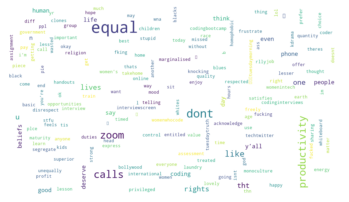

In [ ]:
brandname = "equalsg"
### We're using one of the utility function! "read_word_count_file"
fullTermsDict = read_word_count_file(f'word_counts/equalsg_dict.csv')
outputfile = f"./plot/wordcloud_count_unigram_{brandname}"
makeImage(fullTermsDict, outputfile)

"men"

In [ ]:
df_city = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
    'men near:"Singapore" within:10km lang:en since:'+  from_date + ' until:' + end_date + ' -filter:links -filter:replies -filter:retweets').get_items(), 10000))[['date', 'content']]

In [ ]:
loc = '1.3521, 103.8198, 10km'
df_coord = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper(
    'men geocode:"{}"'.format(loc) + 'lang:en since:' +  from_date + ' until:' + end_date + ' -filter:links -filter:replies -filter:retweets').get_items(), 10000))[['date', 'content']]

In [ ]:
print(df_city.shape)
print(df_coord.shape)

(678, 2)
(1513, 2)


In [ ]:
common_rows = df_coord.merge(df_city, how='inner')
print(common_rows.shape)
common_rows.head()

(489, 2)


,date,content
0,2020-12-30 04:40:43+00:00,i would spend my last $5 on men but they would...
1,2020-12-30 04:38:12+00:00,ive wasted alot of money trying to support men...
2,2020-12-30 04:37:35+00:00,i need to stop spending my money on men
3,2020-12-30 01:56:02+00:00,Just came to my mind: Why is it ok for @TheEll...
4,2020-12-26 15:28:04+00:00,Does anyone knows where I can get mens jumpsuit?


In [ ]:
common_rows.to_csv(f'mensg_tweets.csv')

In [ ]:
df = pd.read_csv('mensg_tweets.csv')

print(df.shape)
df.head()

(489, 3)


,Unnamed: 0,date,content
0,0,2020-12-30 04:40:43+00:00,i would spend my last $5 on men but they would...
1,1,2020-12-30 04:38:12+00:00,ive wasted alot of money trying to support men...
2,2,2020-12-30 04:37:35+00:00,i need to stop spending my money on men
3,3,2020-12-30 01:56:02+00:00,Just came to my mind: Why is it ok for @TheEll...
4,4,2020-12-26 15:28:04+00:00,Does anyone knows where I can get mens jumpsuit?


In [ ]:
df['clean_text_1'] = df['content'].apply(clean_text_round1)
df.head()

,Unnamed: 0,date,content,clean_text_1
0,0,2020-12-30 04:40:43+00:00,i would spend my last $5 on men but they would...,i would spend my last on men but they wouldnt...
1,1,2020-12-30 04:38:12+00:00,ive wasted alot of money trying to support men...,ive wasted alot of money trying to support men...
2,2,2020-12-30 04:37:35+00:00,i need to stop spending my money on men,i need to stop spending my money on men
3,3,2020-12-30 01:56:02+00:00,Just came to my mind: Why is it ok for @TheEll...,just came to my mind why is it ok for theellen...
4,4,2020-12-26 15:28:04+00:00,Does anyone knows where I can get mens jumpsuit?,does anyone knows where i can get mens jumpsuit


In [ ]:
df['clean_text_2'] = df['clean_text_1'].apply(clean_text_round2)
df.head()

,Unnamed: 0,date,content,clean_text_1,clean_text_2
0,0,2020-12-30 04:40:43+00:00,i would spend my last $5 on men but they would...,i would spend my last on men but they wouldnt...,would spend last men wouldnt piece shit
1,1,2020-12-30 04:38:12+00:00,ive wasted alot of money trying to support men...,ive wasted alot of money trying to support men...,ive wasted alot money trying support men bc fk...
2,2,2020-12-30 04:37:35+00:00,i need to stop spending my money on men,i need to stop spending my money on men,need stop spending money men
3,3,2020-12-30 01:56:02+00:00,Just came to my mind: Why is it ok for @TheEll...,just came to my mind why is it ok for theellen...,came mind ok theellenshow objectify men isn’t ...
4,4,2020-12-26 15:28:04+00:00,Does anyone knows where I can get mens jumpsuit?,does anyone knows where i can get mens jumpsuit,anyone knows get mens jumpsuit


In [ ]:
mensg = count_words_from_dataframe(df)
my_dict = mensg

with open('word_counts/mensg_dict.csv', 'w') as f:
  for key in my_dict.keys():
    f.write("%s,%s\n"%(key,my_dict[key]))

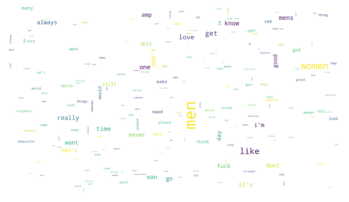

In [ ]:
brandname = "mensg"
### We're using one of the utility function! "read_word_count_file"
fullTermsDict = read_word_count_file(f'word_counts/mensg_dict.csv')
outputfile = f"./plot/wordcloud_count_unigram_{brandname}"
makeImage(fullTermsDict, outputfile)

Log Odds

In [ ]:
### Let's download ```smt203util.py``` Below code should download the file in the same folder where your jupyter notebook is. 
!wget https://raw.githubusercontent.com/anjisun221/css_codes/main/ay21t1/Lab03_text_analysis/smt203util.py

--2021-10-22 15:51:32--  https://raw.githubusercontent.com/anjisun221/css_codes/main/ay21t1/Lab03_text_analysis/smt203util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3034 (3.0K) [text/plain]
Saving to: ‘smt203util.py.3’

smt203util.py.3     100%[===================>]   2.96K  --.-KB/s    in 0.001s  

2021-10-22 15:51:32 (2.92 MB/s) - ‘smt203util.py.3’ saved [3034/3034]



In [ ]:
from smt203util import *

Read mcdonalds CSV

In [ ]:
df = pd.read_csv('./womensg_tweets.csv')

print(df.shape)
df.head()

(276, 3)


,Unnamed: 0,date,content
0,0,2020-12-30 05:25:55+00:00,It’s always fun to eavesdrop on church youth g...
1,1,2020-12-30 04:41:10+00:00,stopppp ruininggggg women
2,2,2020-12-30 03:47:38+00:00,"Without really planning on it, most of the boo..."
3,3,2020-12-26 04:31:20+00:00,I am starting to think there was a secret 14 m...
4,4,2020-12-25 03:24:05+00:00,The Ripper docu clearly telling us — women tha...


In [ ]:
pd.set_option('display.max_colwidth', 150)
df.head()

,Unnamed: 0,date,content
0,0,2020-12-30 05:25:55+00:00,"It’s always fun to eavesdrop on church youth groups having lunch discussions at the food court. Today’s discussion involved 4 youths (3F, 1M) disc..."
1,1,2020-12-30 04:41:10+00:00,stopppp ruininggggg women
2,2,2020-12-30 03:47:38+00:00,"Without really planning on it, most of the books I've read this year have been by women authors, specifically BIPOC authors, and subsequently my l..."
3,3,2020-12-26 04:31:20+00:00,I am starting to think there was a secret 14 men/women orgy at Mandarin Orchard
4,4,2020-12-25 03:24:05+00:00,The Ripper docu clearly telling us — women that most men are bigots and misogynists 🤡


Cleaning the Data

In [ ]:
import re 
import string

def clean_text_round1(text):
    '''Make text lowercase, remove punctuation and words containing numbers and urls.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('^https?:\/\/.*[\r\n]*', '', text)
    return text

In [ ]:
def parseTweet(search_words):
    infilename = f"{mypath}/tweets_{search_words}.jsons"
    outfilename = f"{mypath}/simple_search_tweets_{search_words}.tsv" 
    with open(infilename) as fi, open(outfilename, 'w') as output:
        # Write header in the file to load the file into dataframe
        output.write("\t".join(['tweetid', 'user_screen_name', 'created_at', 'text'])+"\n")

        for line_cnt, line in enumerate(fi):
            try:
                tweet = json.loads(line.strip())
            except: # The last json is not complate 
                continue

            if 'limit' in tweet:
                continue

            tweetid = tweet['id']

            created_at = tweet['created_at']
            user_screen_name = tweet['user']['screen_name']

            text = tweet['text']

            text = " ".join(text.split())

            output.write("\t".join([str(tweetid), user_screen_name, created_at, text])+"\n")

In [ ]:
#After removing punctuation and numbers
df['clean_text_1'] = df['text'].apply(clean_text_round1)
df.head()

KeyError: ignored

Remove Stopwords

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
def clean_text_round2(text):
    return ' '.join([word for word in text.split() if word not in (stop)])

In [ ]:
df['clean_text_2'] = df['clean_text_1'].apply(clean_text_round2)
df.head()

KeyError: ignored

Counting words and save it to a file

In [ ]:
## Create ```word_counts``` folder 
import os
os.makedirs('word_counts', exist_ok=True)

In [ ]:
# this function create a dictionary with word counts from dataframe 
def count_words_from_dataframe(df):
    result_dict = {}
    # iterate rows of dataframe 
    for index, row in df.iterrows():
        text = row['clean_text_2']
        
        # this will split a sentence into words 
        tokens = text.split()
        
        # iterate each word 
        for i in range(0, len(tokens)):
            token = tokens[i]
            try:
                result_dict[token] += 1
            except KeyError:
                result_dict[token] = 1
                    
    return result_dict

In [ ]:
women_words = count_words_from_dataframe(df)
my_dict = women_words

with open('womensg_dict.csv', 'w') as f:
  for key in my_dict.keys():
    f.write("%s,%s\n"%(key,my_dict[key]))

KeyError: ignored

Draw wordcloud

In [ ]:
### Import relevant libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import re
from PIL import Image
from os import path
import csv

### this function will creat wordcloud based on word frequencies and save them into files under plot. 
def makeImage(termDict, outputfile):
    
    wc = WordCloud(max_font_size=60, width=1280, height=720, background_color="white")    

    ### generate word cloud using frequencies!
    wc.generate_from_frequencies(termDict)
    wc.to_file(outputfile+".png")
    wc.to_file(outputfile+".pdf")
    
    ### show the figure
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show() 

In [ ]:
### Create ```plot``` folder 
os.makedirs('plot', exist_ok=True)

In [ ]:
brandname = "womensg"
### We're using one of the utility function! "read_word_count_file"
fullTermsDict = read_word_count_file(f'{mypath}/womensg_dict.csv')
outputfile = f"./plot/wordcloud_count_unigram_{brandname}"
makeImage(fullTermsDict, outputfile)

**Burger King tweets**

Read burger kings CSV

In [ ]:
df = pd.read_csv('./mensg_tweets.csv')

print(df.shape)
df.head()

In [ ]:
import re 
import string

def clean_text_round1(text):
    '''Make text lowercase, remove punctuation and words containing numbers and urls.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('^https?:\/\/.*[\r\n]*', '', text)
    return text

In [ ]:
#After removing punctuation and numbers
df['clean_text_1'] = df['text'].apply(clean_text_round1)
df.head()

Remove Stopwords

In [ ]:
import nltk
nltk.download('stopwords')

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
def clean_text_round2(text):
    return ' '.join([word for word in text.split() if word not in (stop)])

In [ ]:
df['clean_text_2'] = df['clean_text_1'].apply(clean_text_round2)
df.head()

Counting words and save it to a file

In [ ]:
## Create ```word_counts``` folder 
import os
os.makedirs('word_counts', exist_ok=True)

In [ ]:
# this function create a dictionary with word counts from dataframe 
def count_words_from_dataframe(df):
    result_dict = {}
    # iterate rows of dataframe 
    for index, row in df.iterrows():
        text = row['clean_text_2']
        
        # this will split a sentence into words 
        tokens = text.split()
        
        # iterate each word 
        for i in range(0, len(tokens)):
            token = tokens[i]
            try:
                result_dict[token] += 1
            except KeyError:
                result_dict[token] = 1
                    
    return result_dict

In [ ]:
mensg_words = count_words_from_dataframe(df)
my_dict = mensg_words

with open('mensg_dict.csv', 'w') as f:
  for key in my_dict.keys():
    f.write("%s,%s\n"%(key,my_dict[key]))

Draw wordcloud

In [ ]:
### Import relevant libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import re
from PIL import Image
from os import path
import csv

### this function will creat wordcloud based on word frequencies and save them into files under plot. 
def makeImage(termDict, outputfile):
    
    wc = WordCloud(max_font_size=60, width=1280, height=720, background_color="white")    

    ### generate word cloud using frequencies!
    wc.generate_from_frequencies(termDict)
    wc.to_file(outputfile+".png")
    wc.to_file(outputfile+".pdf")
    
    ### show the figure
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show() 

In [ ]:
### Create ```plot``` folder 
os.makedirs('plot', exist_ok=True)

In [ ]:
brandname = "mensg"
### We're using one of the utility function! "read_word_count_file"
fullTermsDict = read_word_count_file(f'{mypath}/mensg_dict.csv')
outputfile = f"./plot/wordcloud_count_unigram_{brandname}"
makeImage(fullTermsDict, outputfile)

Representitve words using log odds 

In [ ]:
### Getting global word counts (frequency of unigram in Google News datasets)
target_url = "https://raw.githubusercontent.com/anjisun221/css_codes/main/ay21t1/Lab03_text_analysis/1gram_englishall_count.csv"
global_counts = read_word_count_file_online(target_url)
print("The number of unigrams=", len(global_counts))

In [ ]:
### Removing stopwords from the word list 
stopwords_list = get_stopwords()
global_counts = {k: v for k, v in global_counts.items() if (k not in stopwords_list) and (len(k) > 2)}
print("After excluding stop words: ", len(global_counts))

Load word frequency file and create dictionary of tweets of 2 keywords

In [ ]:
counts_i_name = "womensg"

counts_i = read_word_count_file(f"{mypath}/{counts_i_name}_dict.csv")

### we filter out words that exist in our background corpus
counts_i_dict = {k: v for k, v in counts_i.items() if k in global_counts}

In [ ]:
counts_j_name = 'mensg'

counts_j = read_word_count_file(f"{mypath}/{counts_j_name}_dict.csv")

### we filter out words that exist in our background corpus
counts_j_dict = {k: v for k, v in counts_j.items() if k in global_counts}

In [ ]:
top_words_df = calculate_log_odds_idp(global_counts, counts_i_name, counts_i_dict, counts_j_name, counts_j_dict)

log_odds_z_score

In [ ]:
top_words_df[top_words_df[counts_i_name] >= 5].head(20)

In [ ]:
top_words_df[top_words_df[counts_j_name] >= 2].iloc[::-1].head(20)

In [ ]:
find_discriminative_words(top_words_df, threshold_i=2, threshold_j=2, num_i=20, num_j=20, mypath='.')

Word clouds based on log odds value

**Mcdonald tweets**

In [ ]:
fullTermsDict = read_word_count_file(f"{mypath}/{counts_i_name}_zscore.csv")
outputfile = f"./plot/wordcloud_log_odds_unigram_{counts_i_name}_compared with_{counts_j_name}"
makeImage(fullTermsDict, outputfile)

**Burger King tweets**

In [ ]:
fullTermsDict = read_word_count_file(f"{mypath}/{counts_j_name}_zscore.csv")
outputfile = f"./plot/wordcloud_log_odds_unigram_{counts_j_name}_compared_with_{counts_i_name}"  
makeImage(fullTermsDict, outputfile)